ResNet-18 

In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [24]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import numpy as np
train_dir = r"C:\Users\Admin\Downloads\BoneFractureDataset\training"
test_dir = r"C:\Users\Admin\Downloads\BoneFractureDataset\testing"

In [15]:
#Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),               
    transforms.ToTensor(),                       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# Load training and testing data
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset class labels
class_names = train_dataset.classes
print(f"Class Names: {class_names}")

Class Names: ['fractured', 'not_fractured']


In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)

# 2. Modify the model for feature extraction (removing the final classification layer)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  

resnet18.eval()

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 3.11MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Extract features from pool5 layer
def extract_features(loader):
    resnet18.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, target in loader:
            x = resnet18(inputs)  
            x = x.view(x.size(0), -1)  # To Flatten the output obtained
            features.append(x.numpy())
            labels.append(target.numpy())
    
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

# Extract features from train and test data
train_features_pool5, train_labels = extract_features(train_loader)
test_features_pool5, test_labels = extract_features(test_loader)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

# Split the training data into training and validation sets
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(train_features_pool5, train_labels, test_size=0.2, random_state=42)

# Create models
models_dict = {
    "Discriminant Analysis (DA)": LinearDiscriminantAnalysis(),
    "Gaussian Kernel (GK)": GaussianProcessClassifier(),
    "K-Nearest Neighbor (KNN)": KNeighborsClassifier(),
    "Linear": LogisticRegression(max_iter=1000),
    "Support Vector Machine (SVM)": SVC(),
    "Decision Tree (DT)": DecisionTreeClassifier()
}

# Store results
results = {}

# Evaluate each model
for model_name, model in models_dict.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train_ml, y_train_ml, X_val_ml, y_val_ml)
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Accuracy: {metrics['Accuracy']:.2f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")
    print("-" * 50)


Discriminant Analysis (DA):
  Accuracy: 0.93
  Precision: 0.9292
  Recall: 0.9289
  F1 Score: 0.9289
--------------------------------------------------
Gaussian Kernel (GK):
  Accuracy: 1.00
  Precision: 0.9977
  Recall: 0.9977
  F1 Score: 0.9977
--------------------------------------------------
K-Nearest Neighbor (KNN):
  Accuracy: 0.99
  Precision: 0.9944
  Recall: 0.9944
  F1 Score: 0.9944
--------------------------------------------------
Linear:
  Accuracy: 0.94
  Precision: 0.9357
  Recall: 0.9357
  F1 Score: 0.9357
--------------------------------------------------
Support Vector Machine (SVM):
  Accuracy: 0.99
  Precision: 0.9854
  Recall: 0.9853
  F1 Score: 0.9853
--------------------------------------------------
Decision Tree (DT):
  Accuracy: 0.83
  Precision: 0.8274
  Recall: 0.8274
  F1 Score: 0.8274
--------------------------------------------------


In [19]:
resnet18_fc1000 = models.resnet18(pretrained=True)

# Extracting features from fc1000 layer
def extract_features_fc1000(loader):
    resnet18_fc1000.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, target in loader:
            x = resnet18_fc1000(inputs)  
            features.append(x.numpy())  
            labels.append(target.numpy())
    
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

# Extract features from train and test data 
train_features_fc1000, train_labels_fc1000 = extract_features_fc1000(train_loader)
test_features_fc1000, test_labels_fc1000 = extract_features_fc1000(test_loader)

# Train and evaluate ML models on fc1000 features 
X_train_ml_fc, X_val_ml_fc, y_train_ml_fc, y_val_ml_fc = train_test_split(train_features_fc1000, train_labels_fc1000, test_size=0.2, random_state=42)

results_fc1000 = {}

for model_name, model in models_dict.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train_ml_fc, y_train_ml_fc, X_val_ml_fc, y_val_ml_fc)
    results_fc1000[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Print results for fc1000 features
for model_name, metrics in results_fc1000.items():
    print(f"{model_name}:")
    print(f"  Accuracy: {metrics['Accuracy']:.2f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")
    print("-" * 50)


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproces

Discriminant Analysis (DA):
  Accuracy: 0.93
  Precision: 0.9346
  Recall: 0.9346
  F1 Score: 0.9346
--------------------------------------------------
Gaussian Kernel (GK):
  Accuracy: 1.00
  Precision: 0.9972
  Recall: 0.9972
  F1 Score: 0.9972
--------------------------------------------------
K-Nearest Neighbor (KNN):
  Accuracy: 0.99
  Precision: 0.9950
  Recall: 0.9949
  F1 Score: 0.9949
--------------------------------------------------
Linear:
  Accuracy: 0.93
  Precision: 0.9335
  Recall: 0.9334
  F1 Score: 0.9335
--------------------------------------------------
Support Vector Machine (SVM):
  Accuracy: 0.93
  Precision: 0.9319
  Recall: 0.9312
  F1 Score: 0.9312
--------------------------------------------------
Decision Tree (DT):
  Accuracy: 0.82
  Precision: 0.8209
  Recall: 0.8206
  F1 Score: 0.8207
--------------------------------------------------


Classification Report for Discriminant Analysis (DA):
               precision    recall  f1-score   support

    fractured       0.94      0.91      0.93       863
not_fractured       0.92      0.94      0.93       910

     accuracy                           0.93      1773
    macro avg       0.93      0.93      0.93      1773
 weighted avg       0.93      0.93      0.93      1773



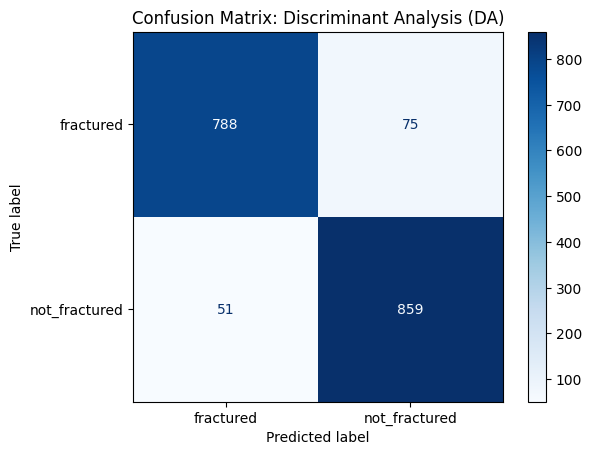

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

# Function to plot Confusion Matrix and Classification Report
def plot_metrics(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Classification Report
    cr = classification_report(y_test, y_pred, target_names=train_dataset.classes)
    print(f"Classification Report for {model_name}:\n{cr}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    
    # Plot of the Confusion Matrix
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

# Example usage for one of the models
DA_model = LinearDiscriminantAnalysis()  # used  DA since it has high acc
plot_metrics(DA_model, X_train_ml, y_train_ml, X_val_ml, y_val_ml, "Discriminant Analysis (DA)")


Classification Report for KNeighborsClassifier(KNN):
               precision    recall  f1-score   support

    fractured       1.00      0.99      0.99       863
not_fractured       0.99      1.00      0.99       910

     accuracy                           0.99      1773
    macro avg       0.99      0.99      0.99      1773
 weighted avg       0.99      0.99      0.99      1773



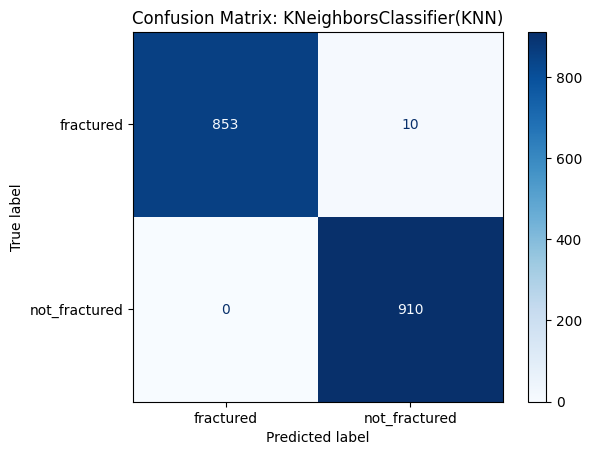

In [21]:
knn_model = KNeighborsClassifier()  
plot_metrics(knn_model, X_train_ml, y_train_ml, X_val_ml, y_val_ml, "KNeighborsClassifier(KNN)")


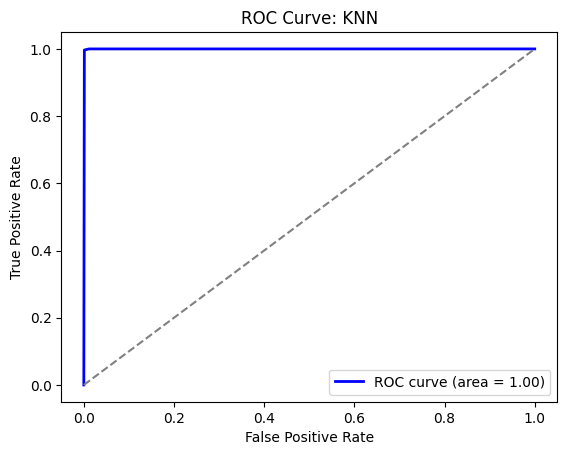

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Function to plot ROC curve 
def plot_roc_curve(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)

    if y_pred_prob.shape[1] == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    else:
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        n_classes = y_test_bin.shape[1]
        
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='best')
    plt.show()

# Example usage for one of the models
plot_roc_curve(knn_model, X_train_ml, y_train_ml, X_val_ml, y_val_ml, "KNN")


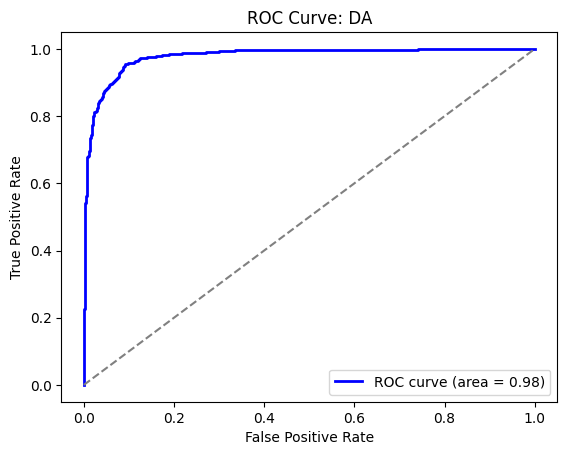

In [27]:
plot_roc_curve(DA_model, X_train_ml, y_train_ml, X_val_ml, y_val_ml, "DA")